# Data Lab 10

Skill scores for probability forecasts. 
- Brier
- Reliability
- Log score
- Ensembles 
- Nino 3.4 forecasts from the North American Multimodel ensemble.

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

## 1. Skill scores 

Review

### 1.1 Deterministic (format of the forecast: single number forecast)

Compare conditional mean $E[y | x ]$ with observations

- Anomaly correlation (AC)
- Mean squared error (MSE)
- MSE skill score (MSESS)

### 1.2 Probabilistic forecasts (categorical)

Provide the probability $F$ of the occurrence of an event $O$

- Reliability (diagram) $E[O | F ] = F$?
- Brier score
    - A balance of reliability and sharpness (resolution)
- Brier skill score
- Ranked probability score (and skill score)

#### 1.2.1 Example

In [3]:
# Simulate forecasts and observations
from scipy import stats

N = 1000 #number of forecasts
beta = 0.75
sigma_e = np.sqrt(1 - beta**2)

# x's for different forecasts 
x = np.random.normal(size = N)
epsilon = sigma_e*np.random.normal(size = N)
y = beta*x + epsilon

# observed event
O = y > 0.5;

# forecast of the event
F = 1 - stats.norm.cdf((0.5 - beta*x)/sigma_e)

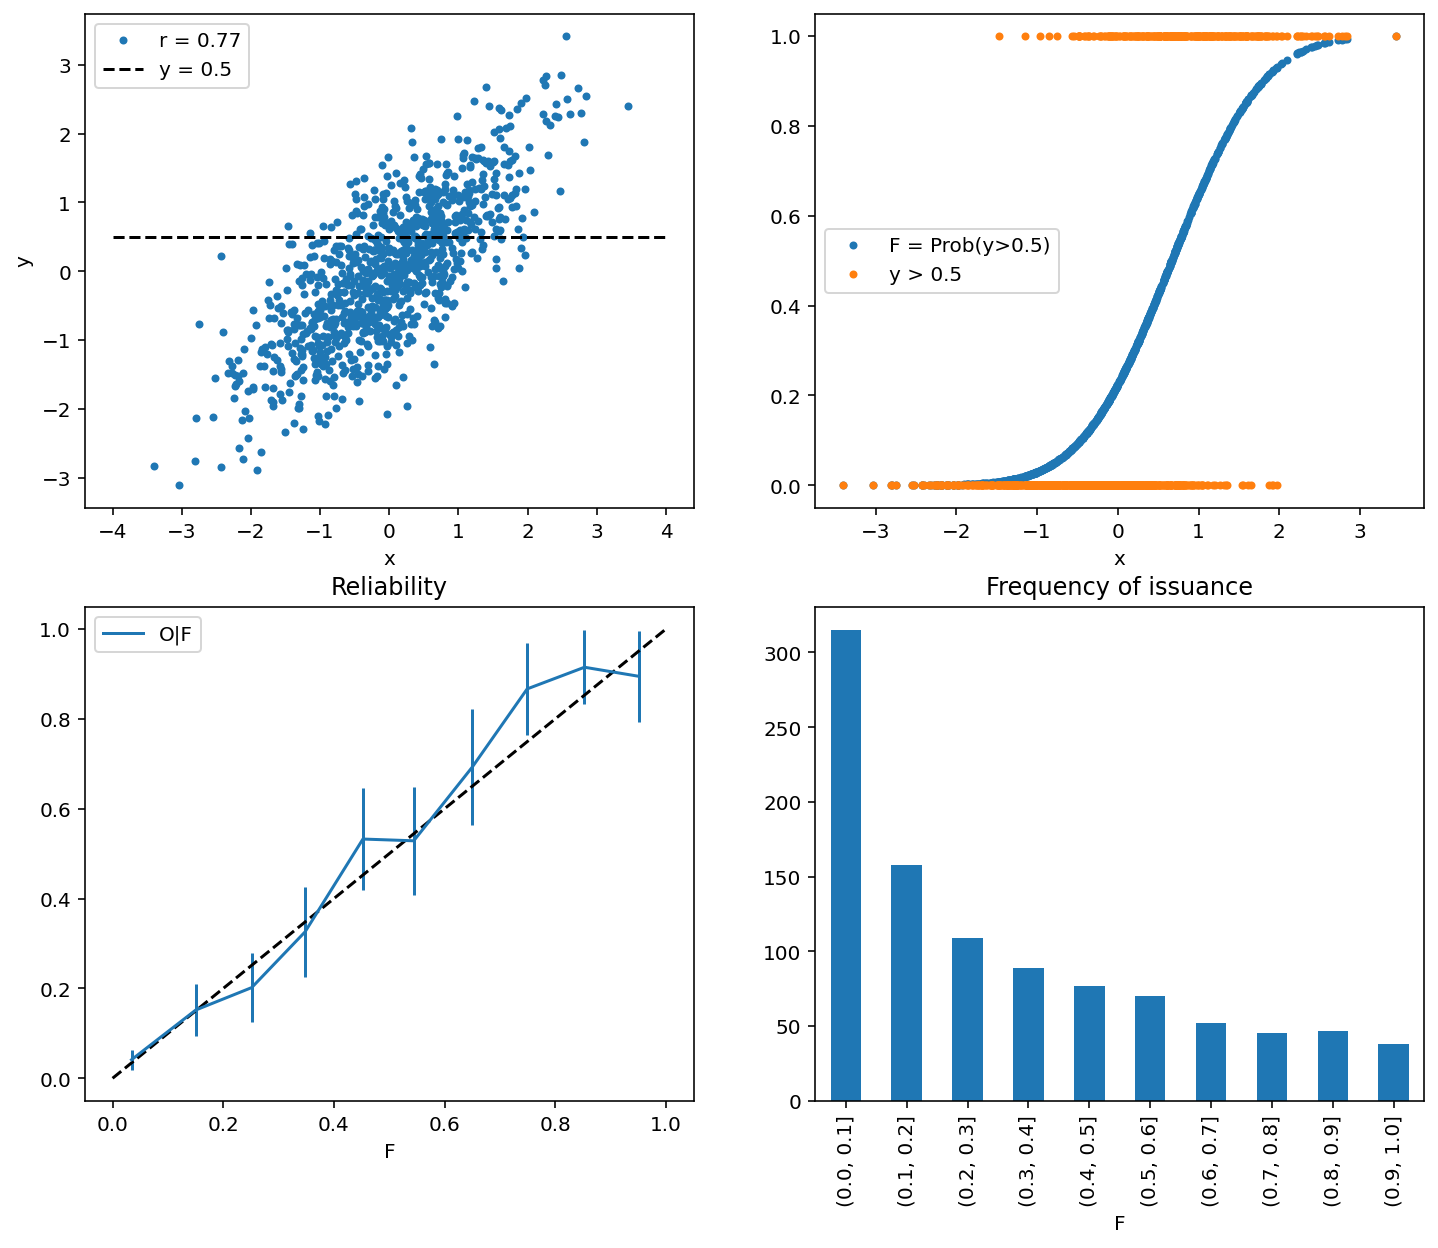

In [4]:
import pandas as pd

df = pd.DataFrame()
df['F'] = F
df['O|F'] = O
df

fbins = pd.cut(df.F, np.linspace(0., 1., 11))
fbins

OcondF = df.groupby(fbins).mean()
yerr = 2*df.groupby(fbins).std()/np.sqrt(df.groupby(fbins).count())

fig, axs = plt.subplots(2, 2, figsize = (12, 10))

label = 'r = {:2.2f}'.format(cor(x,y))
ax = axs[0, 0]
ax.plot(x, y, '.', label = label)
ax.plot((-4, 4), (0.5, 0.5), linestyle = '--', color = 'k', label = 'y = 0.5')
ax.legend();
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = axs[0, 1]
ax.plot(x, F, '.', label = 'F = Prob(y>0.5)')
ax.plot(x, O, '.', label = 'y > 0.5')
ax.set_xlabel('x')
ax.legend();

ax = axs[1, 0]
OcondF.plot(x = 'F', yerr = yerr, ax = ax);
ax.plot((0, 1), linestyle = '--', color = 'k')
ax.set_title('Reliability');

ax = axs[1, 1]
df['F'].groupby(fbins).count().plot(kind = 'bar')
ax.set_title('Frequency of issuance');

In [5]:
BS = np.mean((O - F)**2)
BSc = np.mean((O - np.mean(O))**2)
print(np.mean(O))
print(BS, BSc, 1 - BS/BSc)

0.318
0.13091861693669254 0.21687599999999999 0.39634345461603615


The Brier score is a **proper** score. A proper score is one where the best expected values are obtained when the forecast is equal to  the true probabilities. 

A proper score cannot be "gamed" i.e., improved by tricky business.

The log score is proper score.

### 1.3 Log score

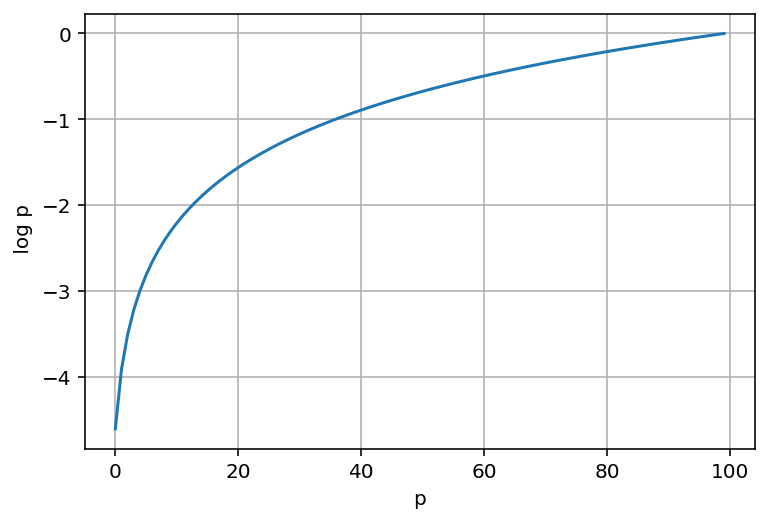

In [6]:
plt.plot(np.log(np.linspace(1, 100, 100)/100));
plt.grid()
plt.xlabel('p')
plt.ylabel(' log p');

#### 1.3.1 Definition

The log score of a forecast is the logarithm of the forecast probability of the event that occured.  
1. The log score is log likelihood of the observations given the forecast probabilities. Larger values are better.
2. The best value is 0, which happens when your forecast is 100% and the event occurs.
3. The worst value is $- \infty$, which happens when your forecast is 100% and the event does not occur.

The sum of the log score of many forecasts can be written:
$$ \text{LS} = \sum_{i=1}^N O_i \log F_i + (1 -O_i) \log (1 - F_i) $$

with the convention that $0 \log 0 = 0$. 

Note that the formula is written for a single-category forecast but the words can be applied to multi-category forecasts.

Example: Suppose that the ENSO forecast probabilities for JJA 2021 are 28% for La Nina conditions, 58% for neutral conditions, and 14% for El Nino conditions.  
- If neutral conditions occur, the log score of the forecast will be $\log 0.58 = -0.54$. 
- If El Nino conditions occur, the log score of the forecast will be $\log 0.14 = -1.97$. 

Other conventions can be used. For instance, a minus sign or dividing by the number of forecasts.

#### 1.3.2 Log skill score

The log skill score is defined 

$$ \text{LSS} = \text{LS} - \text{LS}_{\text{ref}} $$

How is this different from MSESS and BSESS?

A typical reference forecast is the base rate (average of $O$).

In [7]:
# What is going on here?
LS = np.sum(np.log(F[O])) + np.sum(np.log(1 - F[~O]))
Fc = np.full_like(F, np.mean(O))
LSc = np.sum(np.log(Fc[O])) + np.sum(np.log(1 - Fc[~O]))

print(LS, LSc, LS - LSc)

-406.4382935696443 -625.3527126087997 218.9144190391554


### The log score is the only *proper* *local* score.

A proper score is one whose expected value is best when the forecast is equal to the true probabilities.

A local score is one whose value only depends on the category that occurs. (Important for multi-category forecasts)

Example of a non-local score:

- Forecaster A gives probabiities of La Nina, neutral, and El Nino: 45%, 30%, 25%
- Forecaster B gives probabiities of La Nina, neutral, and El Nino: 50%, 15%, 35%
- La Nina occurs

In [8]:
# Log scores
LS_A = np.log(0.45)
LS_B = np.log(0.50)
# Ranked prob. score NOT local
RPS_A = (1 - 0.45)**2 + (0 - 0.25)**2 
RPS_B = (1 - 0.50)**2 + (0 - 0.35)**2
print(LS_A, LS_B)
print(RPS_A, RPS_B)

-0.7985076962177716 -0.6931471805599453
0.36500000000000005 0.3725


### Example of an improper score:

(naive) Linear score: score is the probability of the category that occurs.

- Forecaster A gives probabiities of La Nina, neutral, and El Nino: 45%, 30%, 25%
- Forecaster A gives probabiities of La Nina, neutral, and El Nino: 50%, 15%, 35%
- La Nina occurs

In [9]:
LinScore_A = 0.45
LinScore_B = 0.50

A score is a random variable because it is a function of the verifying observation, which is random.

Suppose the true probabiities of La Nina, neutral, and El Nino are known to be: 52%, 25%, 23%.

Then we can compute the expected value of the linear score

In [10]:
Expected_LinScore_A = 0.52 * 0.45 + 0.25 * 0.30 + 0.23 * 0.25
Expected_LinScore_B = 0.52 * 0.50 + 0.25 * 0.15 + 0.23 * 0.35
print(Expected_LinScore_A, Expected_LinScore_B)

0.3665 0.378


Suppose you know the true probabiities. What forecast should you issue to maximize your expected linear score?

Forecaster C give 100% for La Nina and gets an expected linear score of 0.52. The winner!


#### 1.3.3 Properness and betting

Given uncertain information, how should you allocate your investments?

Suppose you have the opportunity to bet (repeatedly) on the outcome of a coin toss, and you know that the coin lands on heads 60% of the time. What should your strategy be?

Let $F$ be the fraction of your money that you bet on heads. There are two possible outcomes:
1. You win $F$ and now your wealth is proportional to $2F + (1 - F) = 1 + F$
2. You lose $F$ and now your wealth is proportional to $(1 - F)$

Your expected wealth after one bet is therefore proportional to

$$ E[\text{wealth}] = 0.6 (1 + F) + 0.4 (1 - F) = 1 + 0.2 F$$

Clearly, your expected wealth is maximized for $F = 1$. (This is like the linear score, which is an improper score)

What is the problem with this strategy? (You go broke)

Suppose that instead we maximize the expected log of wealth. 
$$E[\log (\text{wealth})] = 0.6 \log (1 + F) + 0.4 \log(1 - F)$$

$$ \frac{d}{dF} E[\log (\text{wealth})] = \frac{0.6}{1 + F} - \frac{0.4}{1 - F} $$

What value of $F$ makes 

$$\frac{d}{dF} E[\log (\text{wealth})] = 0$$

($F = 0.2$)

This is called "betting your beliefs" because it is the same as betting 60% on heads and 40% on tails. Why?

If you bet your beliefs, there are two possible outcomes
1. You get heads, which means that you win $2 \times 0.6 = 1.2$
2. You get tails, which means that you win $2 \times 0.4 = 0.8$  
(Log of winning amount is like the log score)

Kelly criteron

![](images/LogSkillScore.png)

https://link.springer.com/article/10.1007%2Fs00382-017-3721-y

#### 1.3.4 Entropy and information theory

![](images/LogSkillScore2.png)

https://link.springer.com/article/10.1007%2Fs00382-017-3721-y

The log wealth criterion has not been without critics
![](images/Samuelson1.png)

## 2. Ensemble forecasts

Sometimes our models of uncertainty don't results in a tidy formula for forecast distribution $p(y | x)$

![](images/NateSilverProbs.png)

### 2.1 Nonlinearity + randomness

The equations contain random (uncertain) terms, and nonlinearity makes their explict treatment difficult.

Example: Spring equation (Smith, UQ)

$$\ddot{z} + C \dot{z} + Kz = 0 $$

$z(0) = 2$, $\dot{z} (0) = C$

Solution is 

$$ z(t) = 2 e^{-C t/2} \cos \left( t\sqrt{ K - C^2/4} \right) $$

Suppose $K = 20.5$ and $C \sim N(1.5, 0.2^2)$, what is the distribution of $z(t)$?

Why is this "hard"?

2 approaches
1. We know the solution ... linearize (Taylor series)
2. We can solve numerically ... and use random numbers in the calculation to create samples

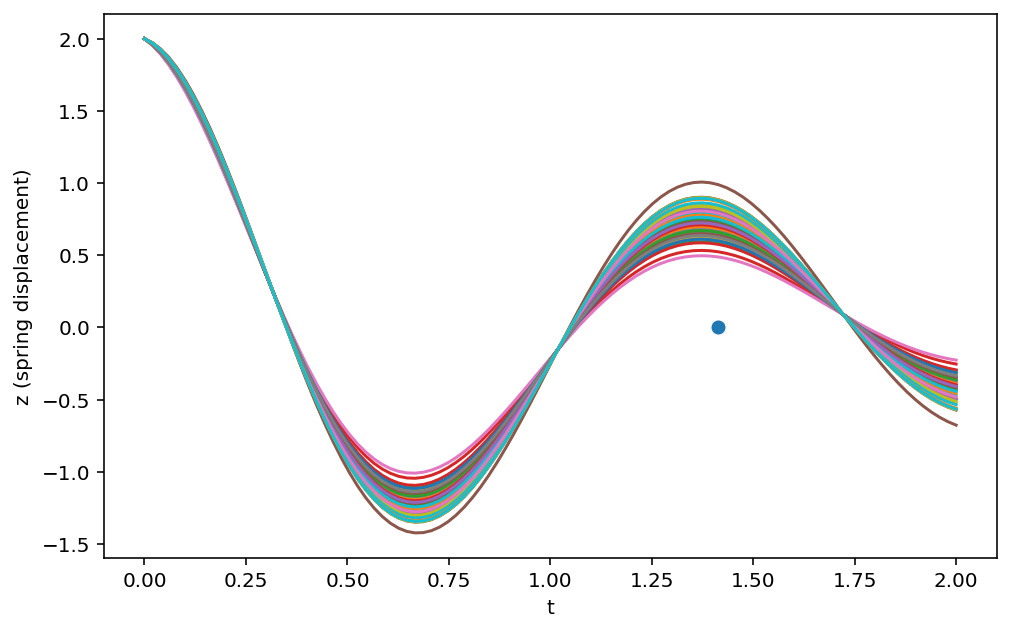

In [11]:
# Ensemble (sample) size
E = 50
nt = 100
t = np.linspace(0, 2, nt)
K = 20.5
C0 = 1.5
sigma_C = 0.2
C = np.random.normal(loc = C0, scale = sigma_C, size = E)
C = C.reshape(1,E)
t = t.reshape(nt, 1)
z = 2 * np.exp(-C * t/2) * np.cos(t * np.sqrt(K - C ** 2/4))

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(t, z,);
ax.plot(t[70], 0, 'o')
ax.set_ylabel('z (spring displacement)')
ax.set_xlabel('t');

[1.41414141]
0.714963030008022
0.24


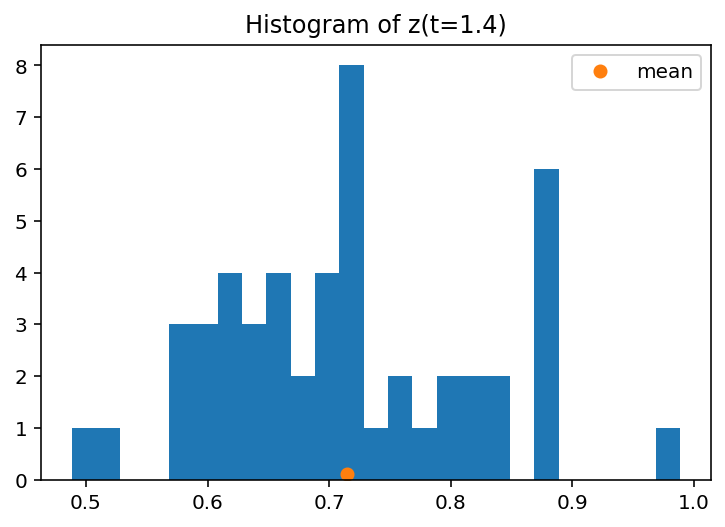

In [12]:
print(t[70])
Y = z[70, :]
print(np.mean(Y))
print(np.mean(Y > 0.8))
plt.hist(Y, bins = 25);
plt.title('Histogram of z(t=1.4)')
plt.plot(np.mean(Y), 0.1, 'o', label = 'mean')
plt.legend();

What might limit the ensemble size? 

What ensemble size is used for climate projections? Weather forecasts? Seasonal climate forecasts?

### 2.2 Deterministic chaos

The equations are deterministic (no random terms), but extreme sensitivity to initial conditions means that solutions appear to be random.

![](images/LHF_2000x1000_O_Lede.gif)

Butterfly effect. 

[Chaos origin story](https://www.quantamagazine.org/hidden-heroines-of-chaos-ellen-fetter-and-margaret-hamilton-20190520/)

[Lorenz info from the Lorenz Center at MIT](https://www.lorenz.mit.edu/edward-n-lorenz)

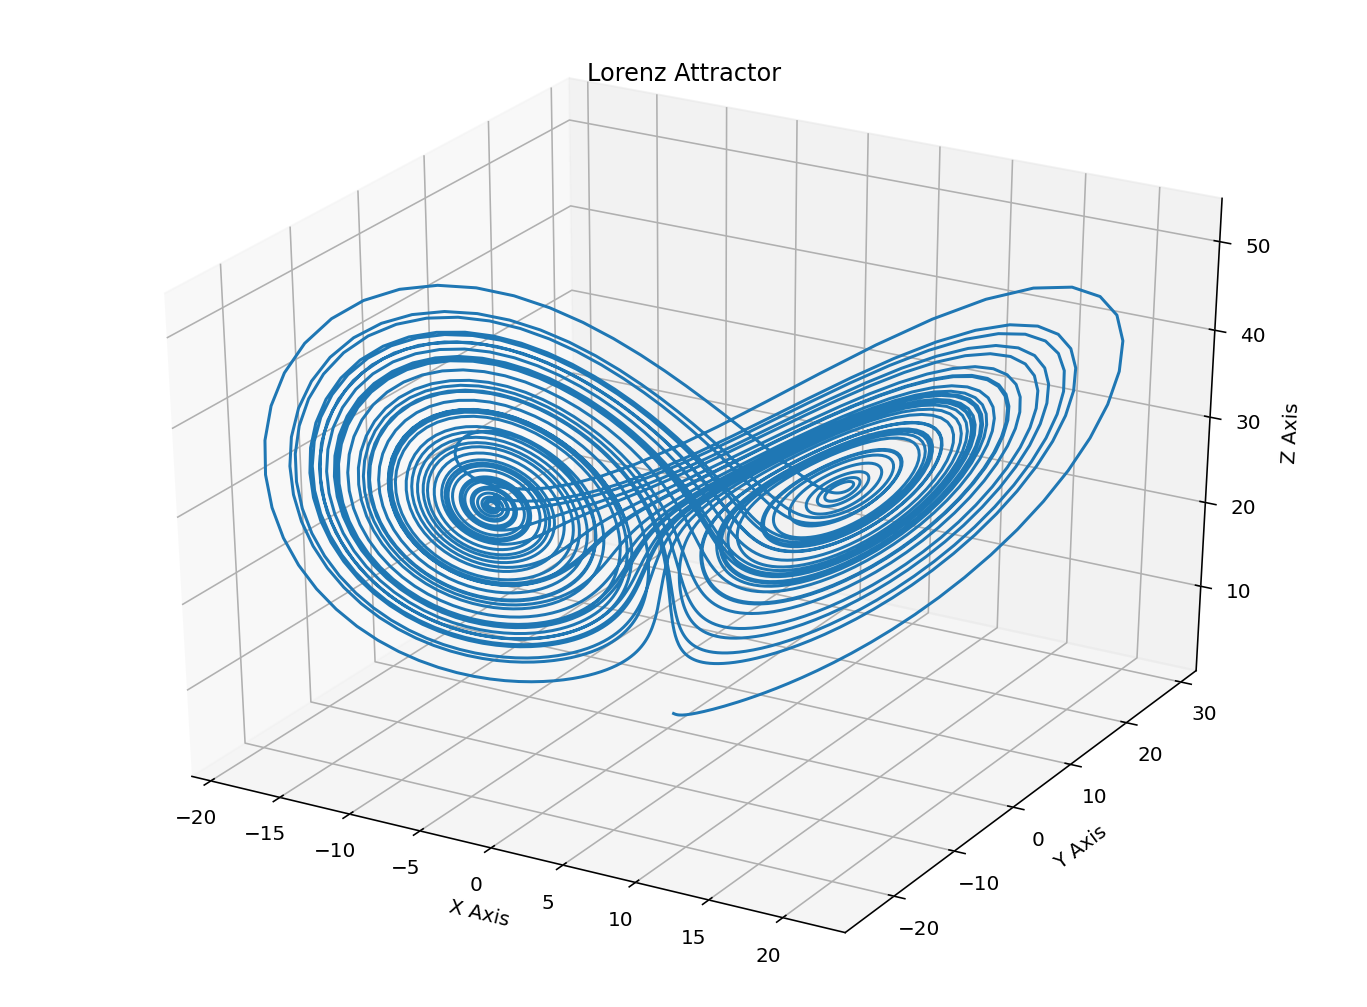

In [13]:
#https://matplotlib.org/3.1.0/gallery/mplot3d/lorenz_attractor.html
# Note

# Because this is a simple non-linear ODE, 
# it would be more easily done using SciPy's ODE solver, 
# but this approach depends only upon NumPy.

def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot



dt = 0.01
num_steps = 5000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

# Plot
fig = plt.figure(figsize = (12, 9))
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs)

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

### 2.3 Atmosphere/ocean models have both 

The atmosphere is chaotic, which limits the skill of weather forecasts beyond a week or two ahead. The ocean is more predictable, and the parts of the atmosphere/ocean system which are related to ENSO are predictable seasons in advance.

Some parameters in models for clouds are uncertain, and the newest models account for this uncertainty using random numbers. (Also different modeling centers make different approximations)

### 2.4 Let's compute forecast probabilities via ensembles

Draw sample of

$$ y = x \beta + \epsilon $$

$ \epsilon \sim N(0, \sigma_{\epsilon}^2) $

In [14]:
E = 20
epsilon = sigma_e*np.random.normal(size = (E, N))
f_ensemble = beta*x + epsilon
f_ensemble.shape

(20, 1000)

0.40658984880837407


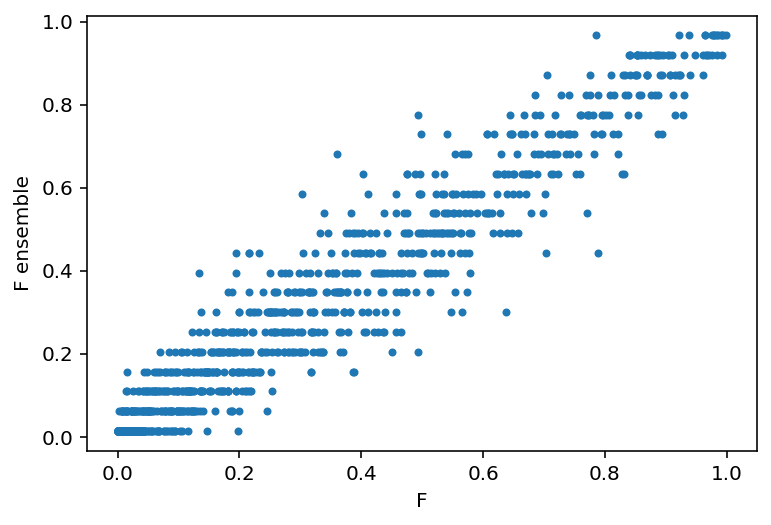

In [15]:
# Fraction of ensemble member that exceed the threshold
#F_ensemble = np.mean(f_ensemble > 0.5, axis = 0)
F_ensemble = (np.sum(f_ensemble > 0.5, axis = 0) + 0.3)/(E + 1)

print((np.mean(F) - np.mean(np.sum(f_ensemble > 0.5, axis = 0)/(E+1)))*(E+1))
plt.plot(F, F_ensemble, '.');
plt.xlabel('F')
plt.ylabel('F ensemble');

Why the "lines"?

Finite ensemble size reduces skill.

In [16]:
# Brier score
np.mean((F - O)**2), np.mean((F_ensemble - O)**2)

(0.13091861693669254, 0.141037641723356)

In [17]:
# log score = log of forecast prob. that occurred. 
np.sum(np.log(F[O])) + np.sum(np.log(1 - F[~O])), np.sum(np.log(F_ensemble[O])) + np.sum(np.log(1 - F_ensemble[~O]))

(-406.4382935696443, -432.09738720077195)

In [18]:
# What happened here?

np.sum( (F_ensemble==0) & O )

0

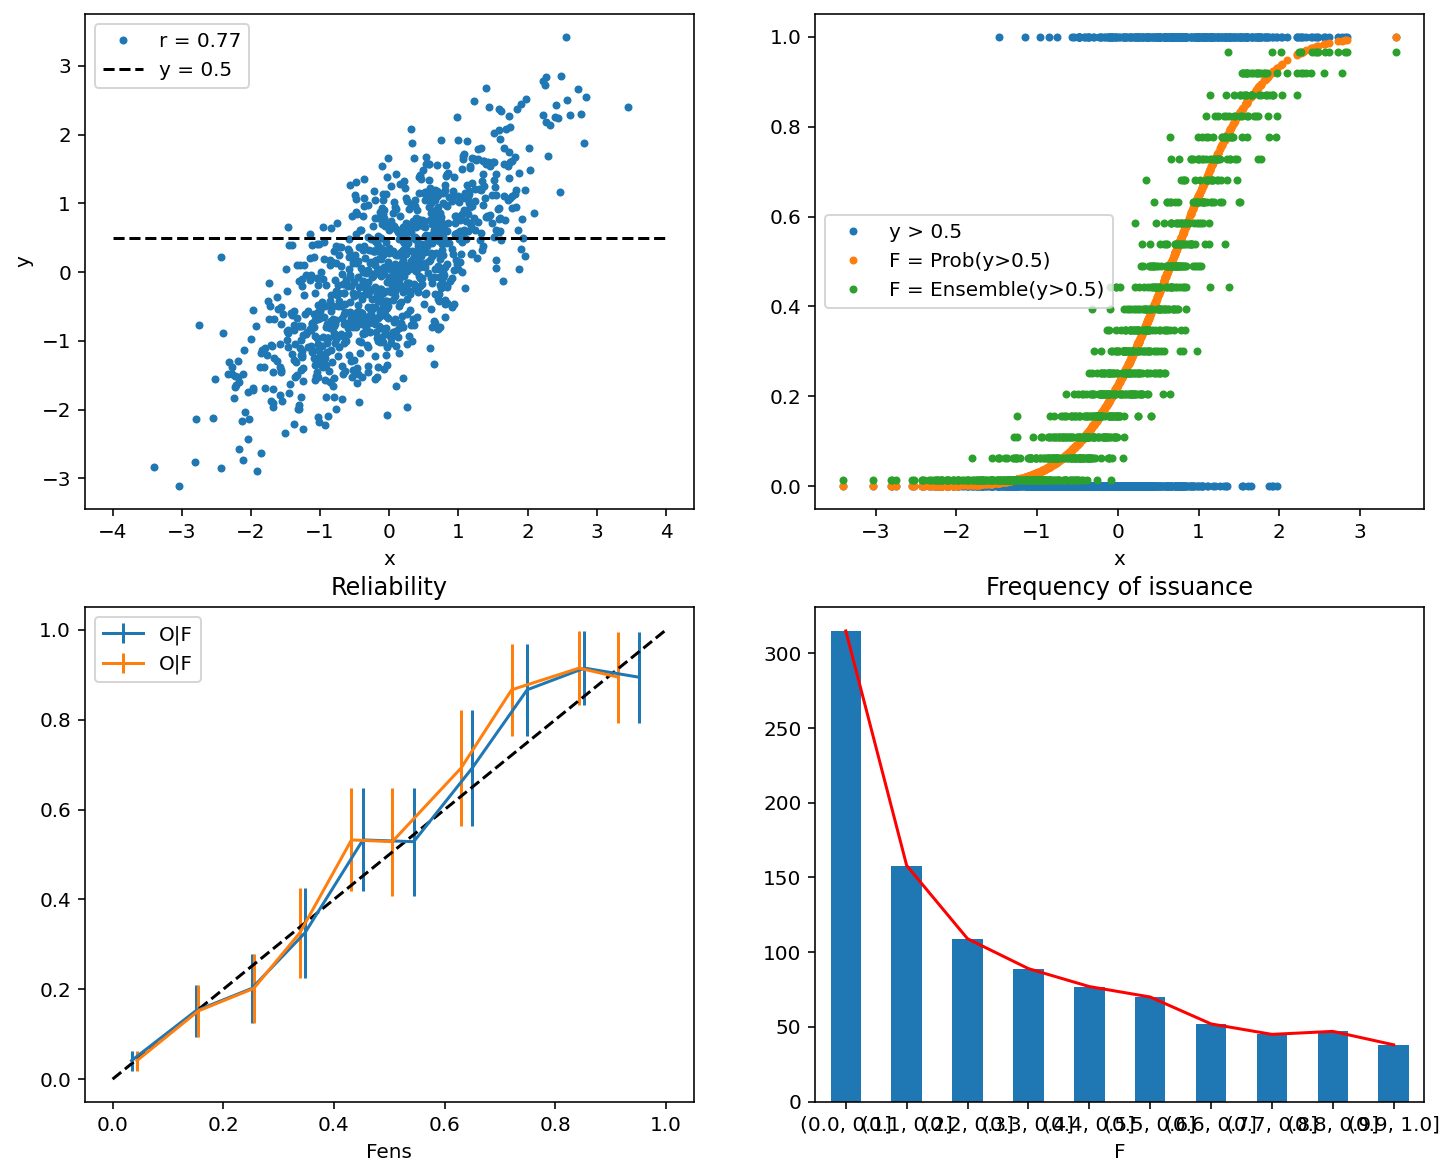

In [19]:
import pandas as pd

#F = F_ensemble

df = pd.DataFrame()
df['F'] = F
df['Fens'] = F_ensemble
df['O|F'] = O
df

fbins = pd.cut(df.F, np.linspace(0., 1., 11))
fbins_ens = pd.cut(df.F, np.linspace(0., 1., 11))


OcondF = df.groupby(fbins).mean()
yerr = 2*df.groupby(fbins).std()/np.sqrt(df.groupby(fbins).count())

OcondF_ens = df.groupby(fbins_ens).mean()
yerr_ens = 2*df.groupby(fbins_ens).std()/np.sqrt(df.groupby(fbins_ens).count())


fig, axs = plt.subplots(2, 2, figsize = (12, 10))

label = 'r = {:2.2f}'.format(cor(x,y))
ax = axs[0, 0]
ax.plot(x, y, '.', label = label)
ax.plot((-4, 4), (0.5, 0.5), linestyle = '--', color = 'k', label = 'y = 0.5')
ax.legend();
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = axs[0, 1]
ax.plot(x, O, '.', label = 'y > 0.5')
ax.plot(x, F, '.', label = 'F = Prob(y>0.5)')
ax.plot(x, F_ensemble, '.', label = 'F = Ensemble(y>0.5)')
ax.set_xlabel('x')
ax.legend();

ax = axs[1, 0]
OcondF.plot(x = 'F', y = 'O|F', yerr = yerr, ax = ax);
OcondF_ens.plot(x = 'Fens', y = 'O|F', yerr = yerr, ax = ax);
ax.plot((0, 1), linestyle = '--', color = 'k')
ax.set_title('Reliability');

ax = axs[1, 1]
df['F'].groupby(fbins).count().plot(kind = 'bar')
df['Fens'].groupby(fbins_ens).count().plot(kind = 'line', color = 'r')
ax.set_title('Frequency of issuance');

Replace properties of the forecast distribution with sample properties computed from the ensemble
- Mean
- Variance
- etc

## 3. CFSv2 forecasts of Nino 3.4

NOAA's Climate Forecast System version 2  
https://journals.ametsoc.org/jcli/article/27/6/2185/34842/The-NCEP-Climate-Forecast-System-Version-2

Highlights
- Coupled ocean/atmosphere/ice/land model
- 24-member ensemble forecasts
- Ensemble members have slightly different initial conditions

Partial differential equations (fluid dynamics, conservation of mass, momentum, and energy) are solved approximately.

**Atmosphere**  
Eigenfunction expansion (spherical harmonics) is used in the horizontal. (equivalent to nearly a 100-km grid resolution)  
Finite differencing in the vertical. (64 levels)

**Ocean**  
- MOM4
- 1/4 degree between 10S and 10N, 1/2 degree poleward of 30S and 30N.
- 40 layers in the vertical with 27 in the upper 400m (bottom depth ~4.5 km)

Overview of the forecast data
- Data are organized as once per month starts
- For a start date of Jan 1, the target of the first lead is Jan.
- Forecasts extend about 9 months

**Hindcasts**  
Before CFSv2 became operational in 2011, a set of *hindcasts* (backtesting, rectrospective forecasts) were made for the period 1982-2010. (There are 292 forecasts for every year for a total of 8468 forecasts)  
- Check skill 
- Fix problems

**Forecast**  
(real-time) forecasts made starting on 2011
- Forecasts about the future
- No chance to fix things

**Data**  
[IRI Data Library](https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.EMC/.CFSv2/.REALTIME_ENSEMBLE/)

In [20]:
365/5*4

292.0

In [21]:
# Check if these urls work on the JupyterHub. If not add to home/.tippett/.scratch/.apma4990

# Nino 3.4
nino34_str = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y/M%5Daverage/'

#Hindcasts
cfsv2_hindcast_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.sst/' + nino34_str + 'dods'

#Hindcast verification times
T_hindcast_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.T/dods'

#Forecasts
cfsv2_forecast_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.sst/' + nino34_str + 'dods'

#Hindcast verification times
T_forecast_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.T/dods'

### 3.1 Hindcasts 1982-2010

In [22]:
cfsv2_hindcast_url

'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y/M%5Daverage/dods'

In [23]:
# Read the hindcasts and add the verification time T
# do not decode the times
cfsv2_hindcast_ds = xr.open_dataset(cfsv2_hindcast_url,decode_times=False)
T_hindcast_ds = xr.open_dataset(T_hindcast_url,decode_times=False)
cfsv2_hindcast_ds['T'] = T_hindcast_ds.T
cfsv2_hindcast_ds

<xarray.Dataset>
Dimensions:  (L: 10, S: 351)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * S        (S) float32 264.0 265.0 266.0 267.0 ... 611.0 612.0 613.0 614.0
Data variables:
    sst      (S, L) float64 ...
    T        (S, L) float32 ...
Attributes:
    Conventions:  IRIDL

### 2.2 Forecasts 2011-present

In [24]:
cfsv2_forecast_url

'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y/M%5Daverage/dods'

In [25]:
# Read the forecasts
# do not decode the times
cfsv2_forecast_ds = xr.open_dataset(cfsv2_forecast_url,decode_times=False)
T_forecast_ds = xr.open_dataset(T_forecast_url,decode_times=False)
cfsv2_forecast_ds['T'] = T_forecast_ds.T
cfsv2_forecast_ds

<xarray.Dataset>
Dimensions:  (L: 10, S: 116)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * S        (S) float32 615.0 616.0 617.0 618.0 ... 727.0 728.0 729.0 730.0
Data variables:
    sst      (S, L) float64 ...
    T        (S, L) float32 ...
Attributes:
    Conventions:  IRIDL

### 2.3 Forecasts + hindcasts

In [26]:
cfsv2_all_ds = xr.concat([cfsv2_hindcast_ds, cfsv2_forecast_ds], dim = 'S')
cfsv2_all_ds

<xarray.Dataset>
Dimensions:  (L: 10, S: 467)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * S        (S) float64 264.0 265.0 266.0 267.0 ... 727.0 728.0 729.0 730.0
Data variables:
    sst      (S, L) float64 26.34 26.62 27.13 27.95 ... 27.75 27.69 27.06 26.09
    T        (S, L) float32 264.5 265.5 266.5 267.5 ... 736.5 737.5 738.5 739.5
Attributes:
    Conventions:  IRIDL

In [27]:
cfsv2_all_ds.S.attrs['long_name'] = 'Start time'

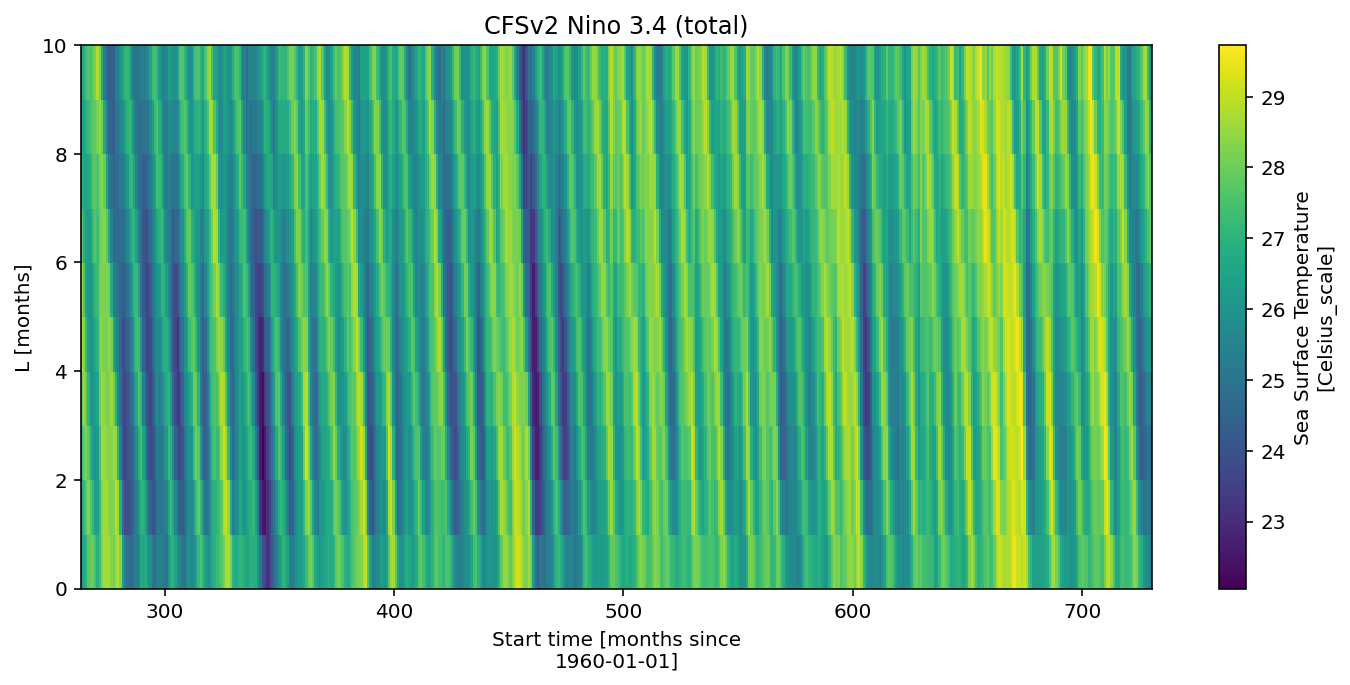

In [28]:
sst = cfsv2_all_ds.sst
S = cfsv2_all_ds.S
L = cfsv2_all_ds.L

sst.plot(x='S', figsize = (12, 5))
plt.title('CFSv2 Nino 3.4 (total)');

Text(0.5, 0, 'Target time')

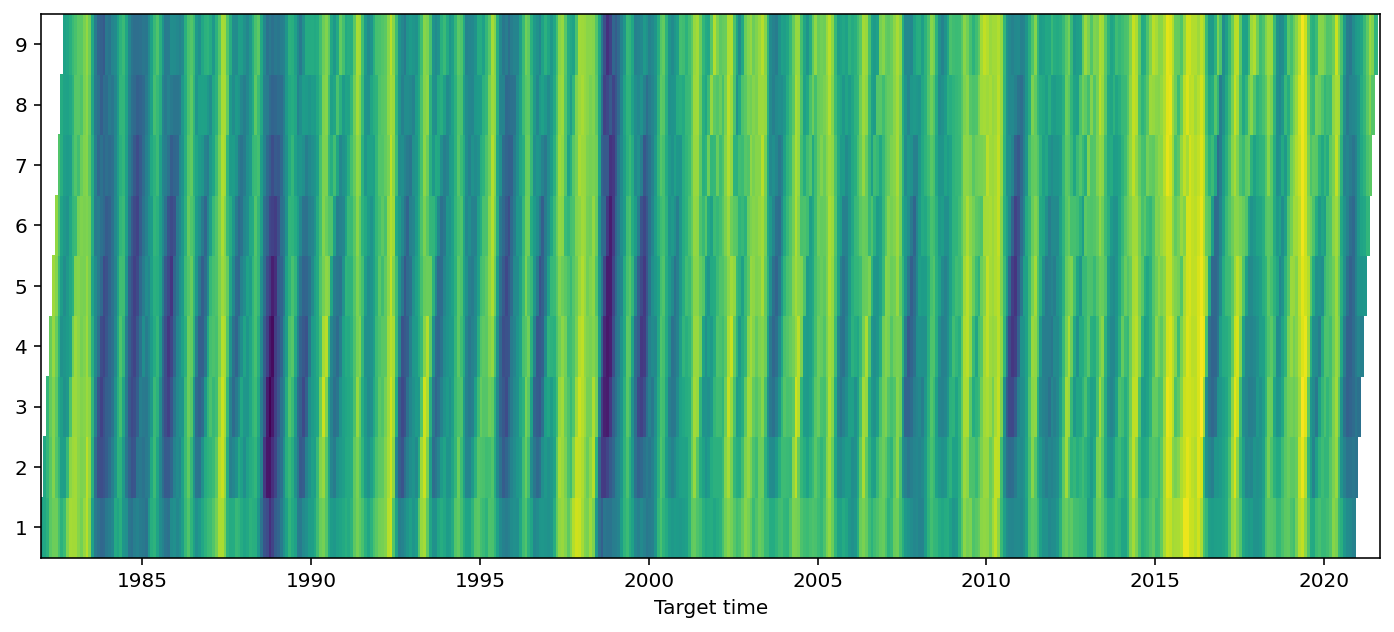

In [29]:
[ns, nl] = sst.shape
sst_target = np.full((ns + nl, nl), np.nan)
for ii in range(0, nl):
    sst_target[ii:(ns + ii), ii] = sst[:, ii]

fig, ax = plt.subplots(figsize = (12, 5))
ax.pcolormesh(np.arange(0, ns + nl)/12 + 1982, L, sst_target.T);
ax.set_xlabel('Target time')

### 2.3.1 Kludge

In [30]:
# Truncate the forecasts at the end of 2019, so that adding the observations is easy below
cfsv2_all_ds = cfsv2_all_ds.isel(S = slice(None, 456))
cfsv2_all_ds

<xarray.Dataset>
Dimensions:  (L: 10, S: 456)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * S        (S) float64 264.0 265.0 266.0 267.0 ... 716.0 717.0 718.0 719.0
Data variables:
    sst      (S, L) float64 26.34 26.62 27.13 27.95 ... 28.3 27.23 26.28 26.05
    T        (S, L) float32 264.5 265.5 266.5 267.5 ... 725.5 726.5 727.5 728.5
Attributes:
    Conventions:  IRIDL

### 2.4 Observations

In [31]:
# Nino 3.4
nino34_str = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'

#Observations OI SST
obs_url = 'http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP/.EMC/.CMB/.GLOBAL/.Reyn_SmithOIv2/.monthly/.sst/' + nino34_str + 'dods'

In [32]:
obs_ds = xr.open_dataset(obs_url,decode_times=False)
o = obs_ds.sst

In [33]:
# add observations to the CFSv2 dataset on the S, L grid
T = cfsv2_all_ds.T
cfsv2_all_ds["obs"] = (( "S", "L"), o.sel(T=T))
cfsv2_all_ds

<xarray.Dataset>
Dimensions:  (L: 10, S: 456)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * S        (S) float64 264.0 265.0 266.0 267.0 ... 716.0 717.0 718.0 719.0
Data variables:
    sst      (S, L) float64 26.34 26.62 27.13 27.95 ... 28.3 27.23 26.28 26.05
    T        (S, L) float32 264.5 265.5 266.5 267.5 ... 725.5 726.5 727.5 728.5
    obs      (S, L) float64 26.72 26.7 27.2 28.02 ... 27.3 26.89 26.18 25.77
Attributes:
    Conventions:  IRIDL

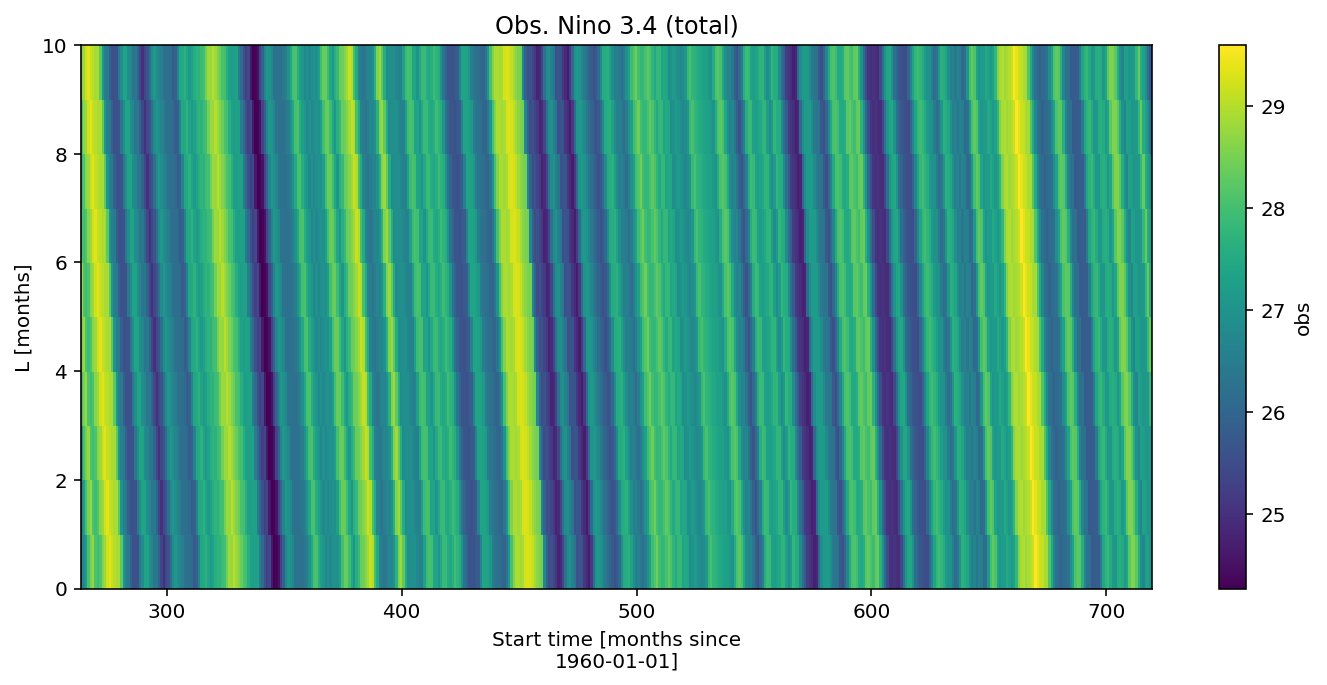

In [34]:
OBS = cfsv2_all_ds.obs.copy()
obs = cfsv2_all_ds.obs
obs.plot(x='S', figsize = (12, 5))
plt.title('Obs. Nino 3.4 (total)');

Text(0.5, 0, 'Target time')

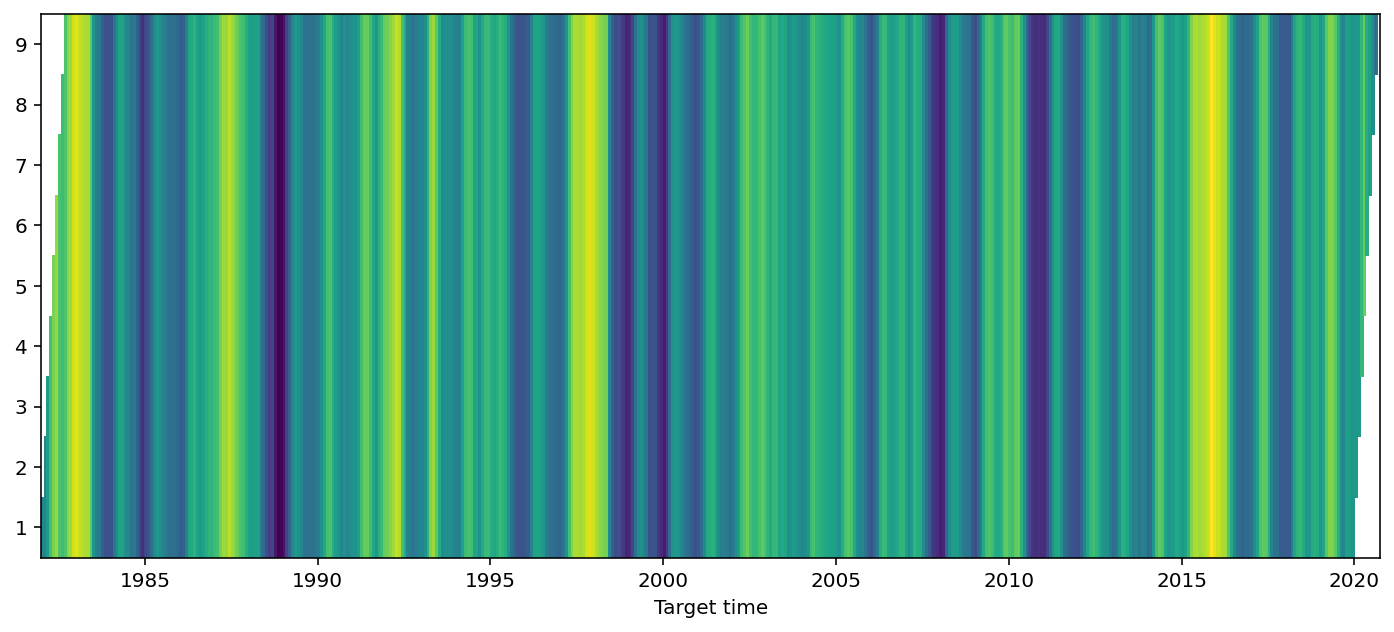

In [35]:
[ns, nl] = obs.shape
obs_target = np.full((ns + nl, nl), np.nan)
for ii in range(0, nl):
    obs_target[ii:(ns + ii), ii] = obs[:, ii]

fig, ax = plt.subplots(figsize = (12, 5))
ax.pcolormesh(np.arange(0, ns + nl)/12 + 1982, L, obs_target.T);
ax.set_xlabel('Target time')

### 2.5 Decode time (carefully)

In [36]:
S = cfsv2_all_ds.S.copy() #keep for later
cfsv2_all_ds['S'].attrs

{'standard_name': 'forecast_reference_time',
 'pointwidth': 0,
 'calendar': '360',
 'gridtype': 0,
 'units': 'months since 1960-01-01',
 'long_name': 'Start time'}

In [37]:
cfsv2_all_ds['S'].attrs['calendar'] = '360_day'
cfsv2_all_ds['S'].attrs

{'standard_name': 'forecast_reference_time',
 'pointwidth': 0,
 'calendar': '360_day',
 'gridtype': 0,
 'units': 'months since 1960-01-01',
 'long_name': 'Start time'}

In [38]:
# decoding T gives an error, maybe don't add T to the ds
cfsv2_all_ds = xr.decode_cf(cfsv2_all_ds, decode_times=True, drop_variables='T')

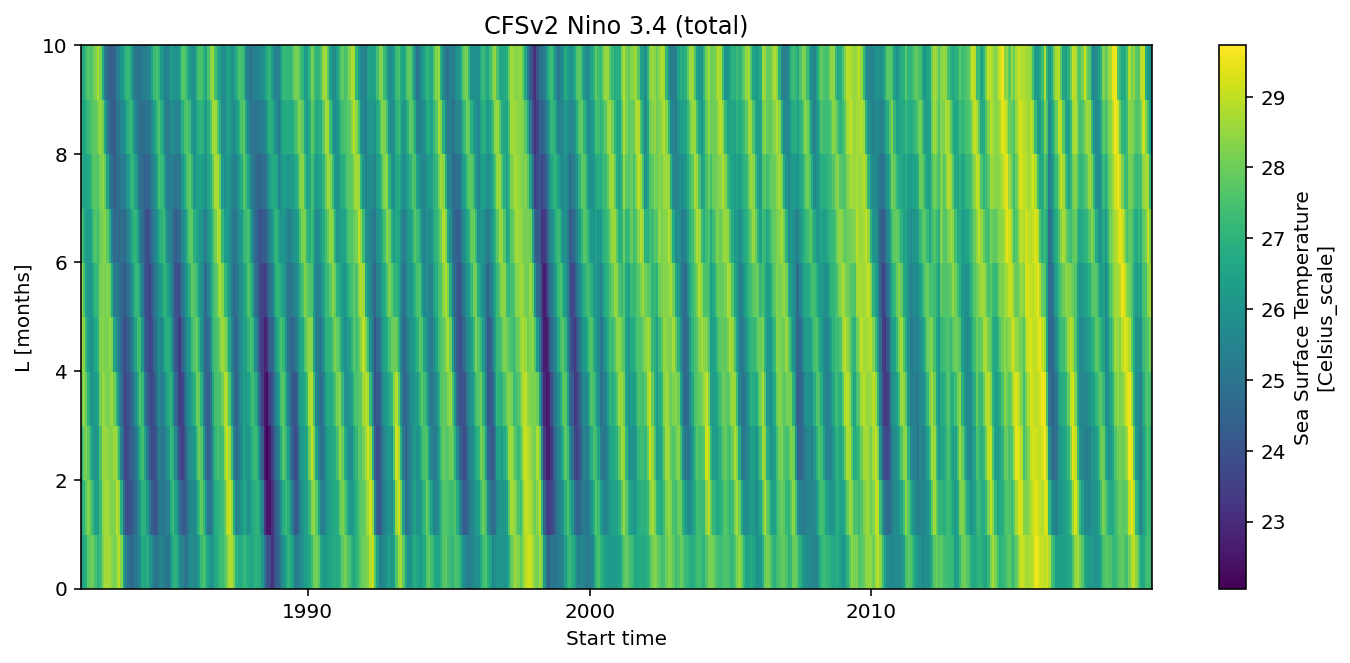

In [39]:
f = cfsv2_all_ds.sst
f.plot(x='S', figsize = (12, 5))
plt.title('CFSv2 Nino 3.4 (total)');

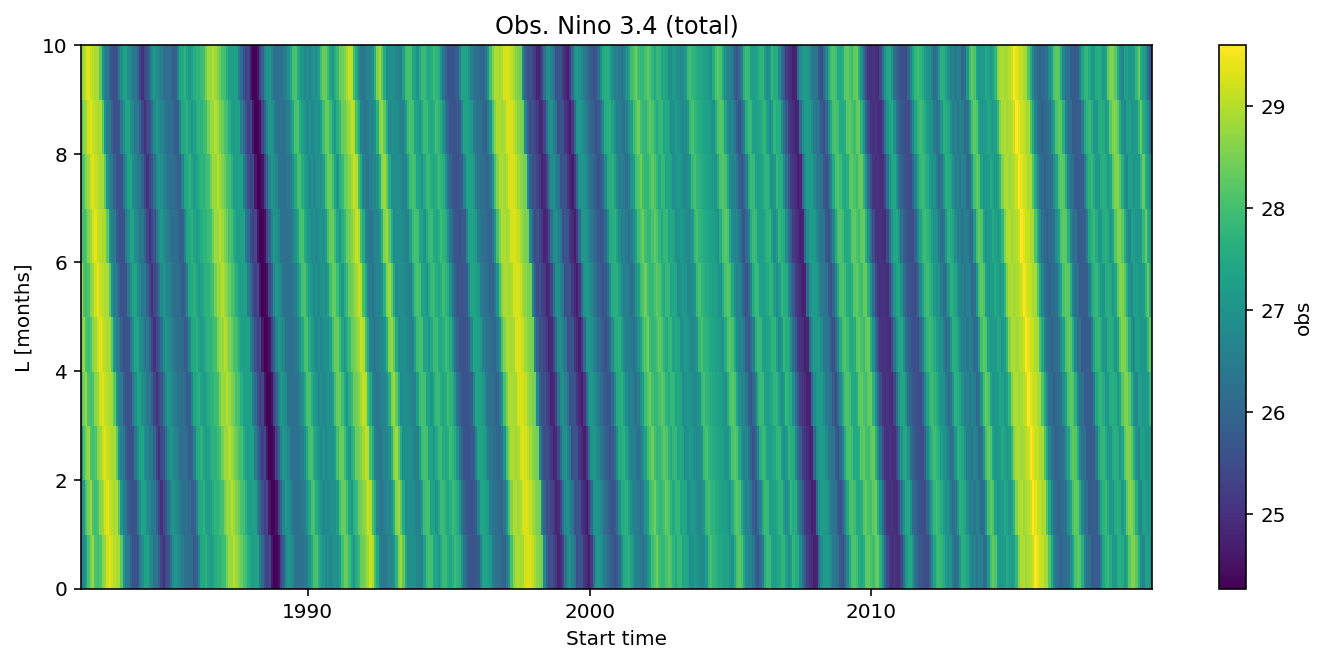

In [40]:
o = cfsv2_all_ds.obs
o.plot(x='S', figsize = (12, 5))
plt.title('Obs. Nino 3.4 (total)');

### 2.6 Forecasts have bias

Bias depends on target month and lead.

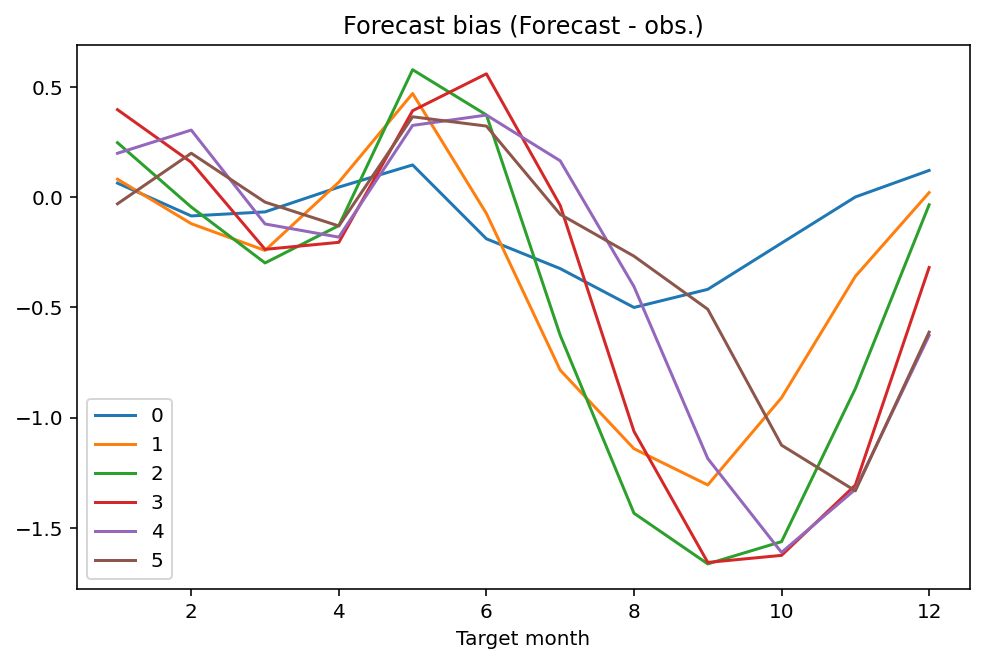

In [41]:
fig, ax = plt.subplots(figsize = (8, 5))

for ii in range(0, 6):
    (f - o)[:,ii].groupby('S.month').mean().roll(month = ii, roll_coords = False).plot(label = ii);

ax.legend()
ax.set_xlabel('Target month')
ax.set_title('Forecast bias (Forecast - obs.)');

## 3. Anomalies. 

### 3.1 Take 1

With respect to the entire period 1982 - 2019

In [42]:
fa = f.groupby("S.month") - f.groupby("S.month").mean("S")
oa = o.groupby("S.month") - o.groupby("S.month").mean("S")
fa

<xarray.DataArray 'sst' (S: 456, L: 10)>
array([[-0.27270073, -0.00485973,  0.17775495, ...,  0.55843734,
         0.57143083,  0.52937178],
       [ 0.01271161,  0.15164212,  0.1862919 , ...,  0.4555408 ,
         0.47998291,  0.4659029 ],
       [-0.22800154, -0.15721588, -0.23218868, ...,  0.02918374,
         0.13445254,  0.14778555],
       ...,
       [ 0.74931798,  0.66862232,  0.53725202, ...,  0.40405129,
         0.05750065, -0.45848941],
       [ 0.70960843,  0.64406301,  0.69082262, ...,  0.49054691,
         0.25545711, -0.10938647],
       [ 0.46056334,  0.4680027 ,  0.4085821 , ...,  0.03761474,
         0.06043445,  0.19544707]])
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * S        (S) object 1982-01-01 00:00:00 ... 2019-12-01 00:00:00
    month    (S) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 1 2 3 4 5 6 7 8 9 10 11 12

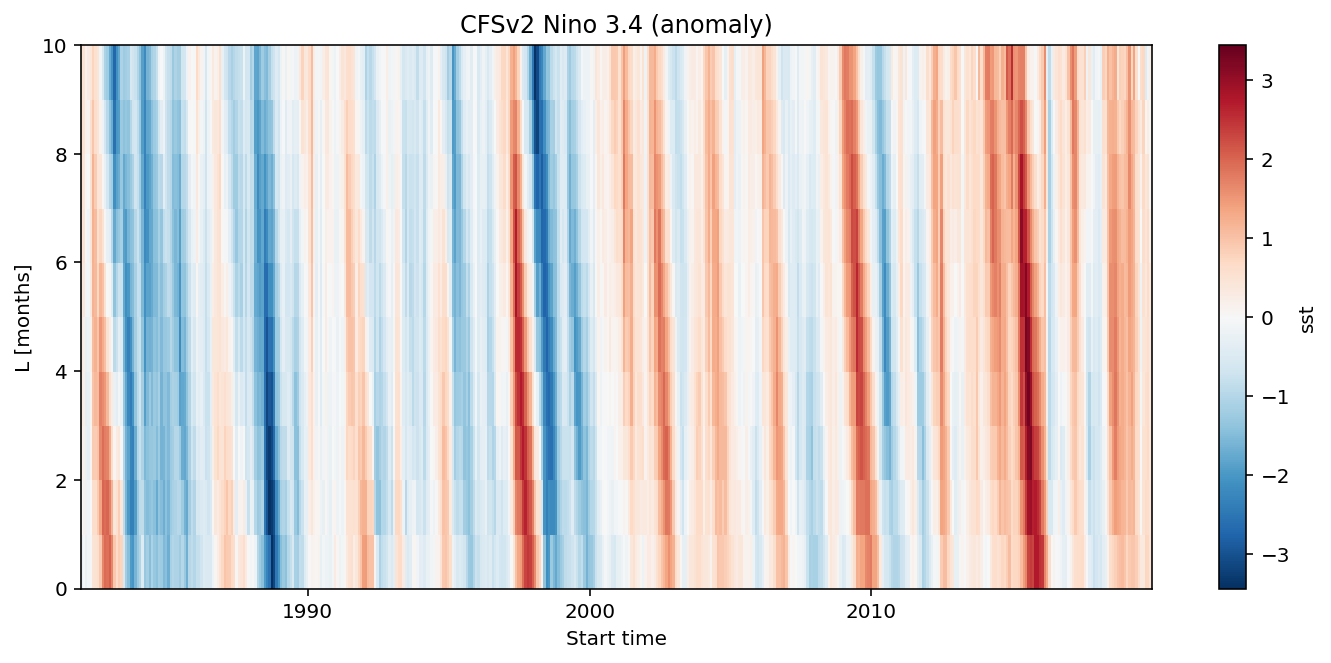

In [43]:
fa.plot(x='S', figsize = (12, 5))
plt.title('CFSv2 Nino 3.4 (anomaly)');

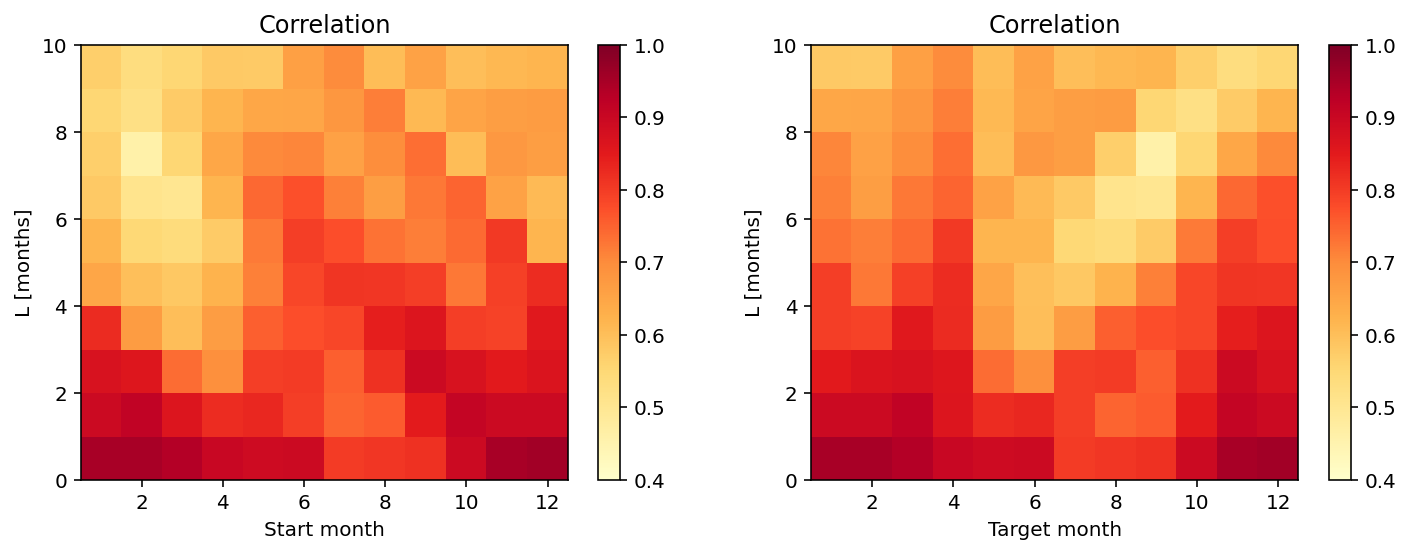

In [44]:
# Compute anomaly correlation as function of start and lead using groupby
ac = (fa*oa).groupby("S.month").mean("S")/fa.groupby("S.month").std("S")/o.groupby("S.month").std("S")

fig, axs = plt.subplots(1, 2, figsize = (12, 4))

ax = axs[0]
ac.plot(x="month",y="L", cmap=plt.cm.YlOrRd, vmin = 0.4, vmax=1.0, ax = ax);
ax.set_title('Correlation');
ax.set_xlabel('Start month');

ac_target = ac.copy()
for ii in range(0, 10):
    ac_target[:, ii] = np.roll(ac[:, ii].values, ii)

ax = axs[1]
ac_target.plot(x="month",y="L", cmap=plt.cm.YlOrRd, vmin = 0.4, vmax=1.0, ax = ax);
ax.set_title('Correlation');
ax.set_xlabel('Target month');

Text(0.5, 1.0, 'Correlation')

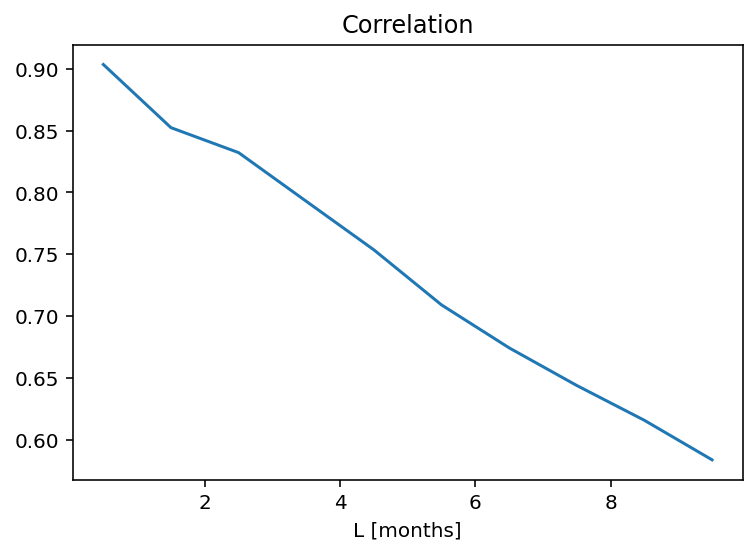

In [45]:
ac = xr.corr(fa, oa, dim = 'S')
ac.plot();
plt.title('Correlation')

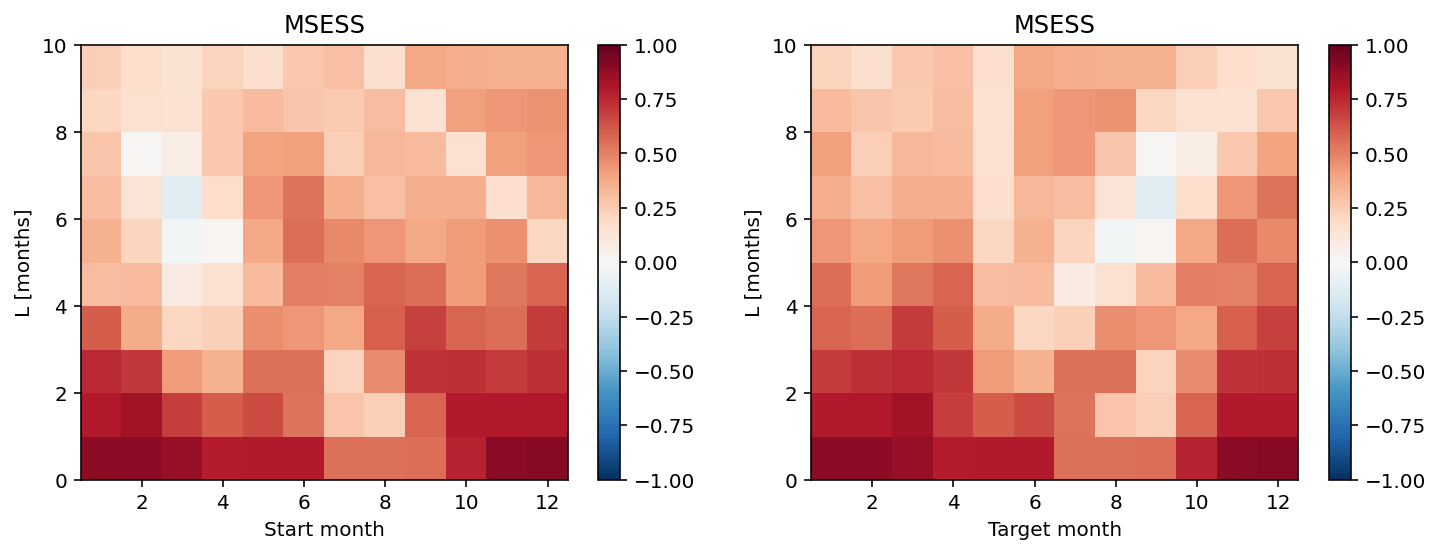

In [46]:
msess = 1 - ((fa-oa)**2).groupby("S.month").mean("S")/oa.groupby("S.month").var("S")

fig, axs = plt.subplots(1, 2, figsize = (12, 4))

ax = axs[0]
msess.plot(x="month",y="L", cmap='RdBu_r', vmax=1.0, ax = ax);
ax.set_title('MSESS');
ax.set_xlabel('Start month');

msess_target = msess.copy()
for ii in range(0, 10):
    msess_target[:, ii] = np.roll(msess[:, ii].values, ii)

ax = axs[1]
msess_target.plot(x="month",y="L", cmap='RdBu_r', vmax=1.0, ax = ax);
ax.set_title('MSESS');
ax.set_xlabel('Target month');

### 3.2 Some problems?

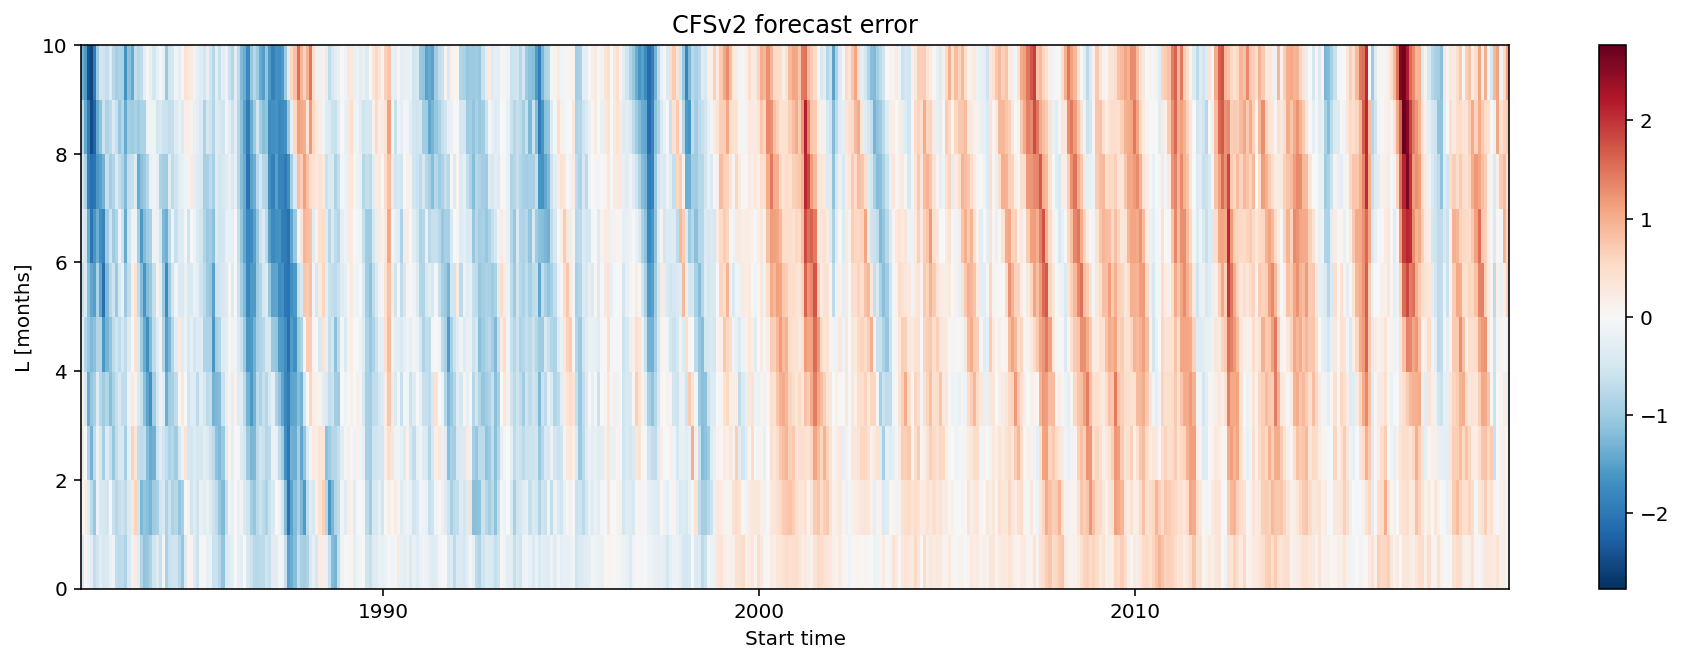

In [47]:
fig, ax = plt.subplots(figsize = (16, 5))
(fa - oa).plot(x = 'S', ax = ax);
plt.title('CFSv2 forecast error');
fig.set_facecolor("white")

What is going one? 

Starting in 1999, forecasts were systematically too warm.
- Not random
- Not climate change

### 3.2.1 *Mistakes were made*

The ocean observing system changed over the hindcast period 1982-2009.

In 1998, new satellites went into operation, and the procedure (data assimilation) for estimating initial conditions from observation failed to properly account for the new data. 

"Within the context of an evolving observing system, of particular interest is the use of the Advanced Television and Infrared Observation Satellite (TIROS) Operational Vertical Sounder (ATOVS) radiance data starting October 1998 that resulted in an abrupt increase in global mean precipitation and changes in other fields in the atmosphere and ocean."

![](images/CFSR-sat.png)

Oops. Especially in the tropical Pacific.

### 3.2.2 Solution: two climatologies

In [48]:
fc82_98 = f.sel(S = slice('1982-01','1998-12')).groupby("S.month").mean("S")
fc99_10 = f.sel(S = slice('1999-01','2010-12')).groupby("S.month").mean("S")

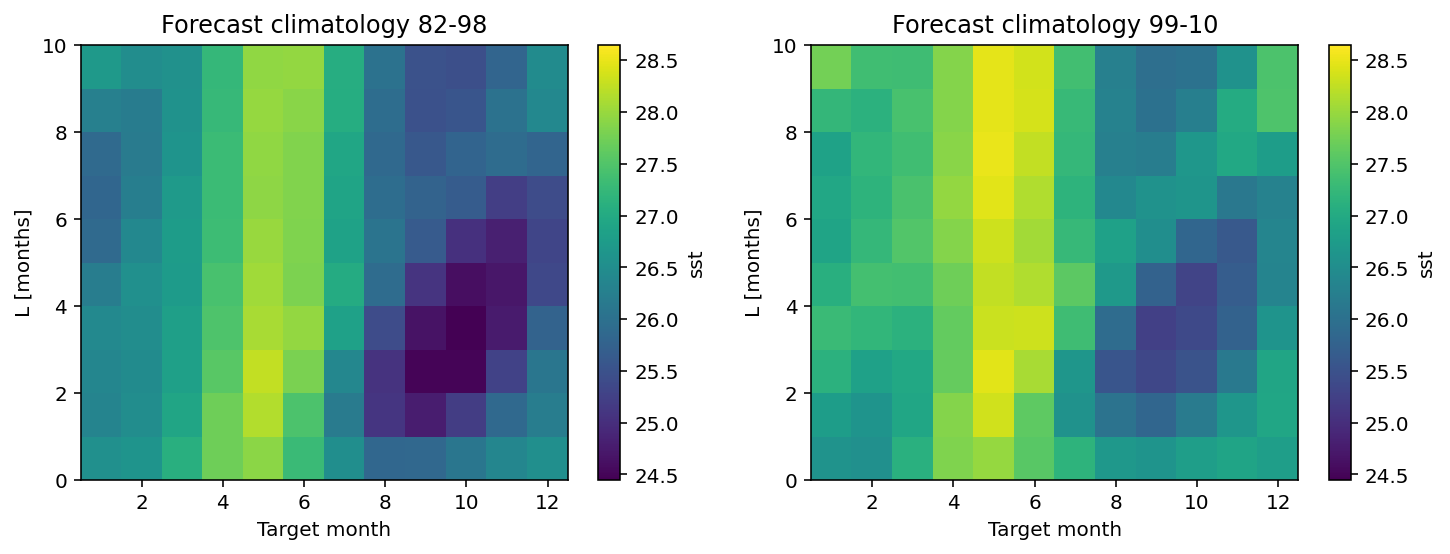

In [49]:
fc82_98_target = fc82_98.copy()
for ii in range(0, 10):
    fc82_98_target[:, ii] = np.roll(fc82_98[:, ii].values, ii)

fc99_10_target = fc99_10.copy()
for ii in range(0, 10):
    fc99_10_target[:, ii] = np.roll(fc99_10[:, ii].values, ii)


fig, axs = plt.subplots(1, 2, figsize = (12, 4))

ax = axs[0]
fc82_98_target.plot(x="month",y="L", vmin = 24.45, vmax = 28.65, ax = ax);
ax.set_title('Forecast climatology 82-98');
ax.set_xlabel('Target month');

ax = axs[1]
fc99_10_target.plot(x="month",y="L",  vmin = 24.45, vmax = 28.65, ax = ax);
ax.set_title('Forecast climatology 99-10');
ax.set_xlabel('Target month');
fig.set_facecolor("white")

Why target/lead time plot?

In [50]:
oc82_98 = o.sel(S = slice('1982-01','1998-12')).groupby("S.month").mean("S")
oc99_10 = o.sel(S = slice('1999-01','2010-12')).groupby("S.month").mean("S")

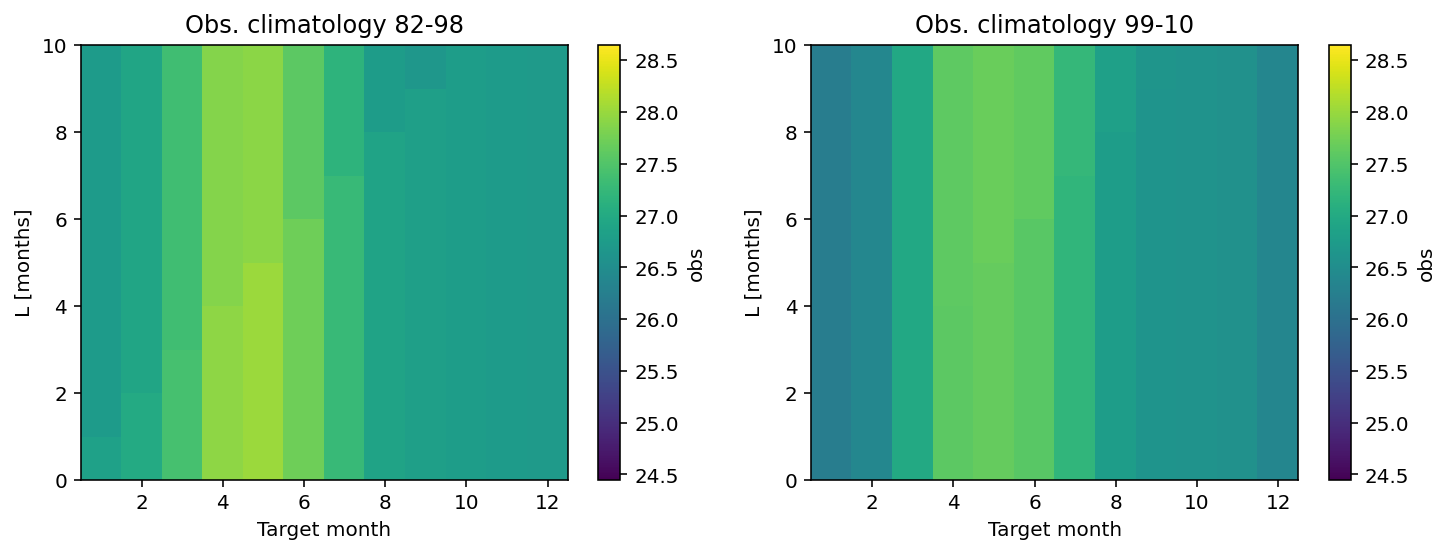

In [51]:
oc82_98_target = oc82_98.copy()
for ii in range(0, 10):
    oc82_98_target[:, ii] = np.roll(oc82_98[:, ii].values, ii)

oc99_10_target = oc99_10.copy()
for ii in range(0, 10):
    oc99_10_target[:, ii] = np.roll(oc99_10[:, ii].values, ii)


fig, axs = plt.subplots(1, 2, figsize = (12, 4))

ax = axs[0]
oc82_98_target.plot(x="month",y="L", vmin = 24.45, vmax = 28.65, ax = ax);
ax.set_title('Obs. climatology 82-98');
ax.set_xlabel('Target month');

ax = axs[1]
oc99_10_target.plot(x="month",y="L",  vmin = 24.45, vmax = 28.65, ax = ax);
ax.set_title('Obs. climatology 99-10');
ax.set_xlabel('Target month');
fig.set_facecolor("white")

Some issues doing this in xarray?

In [52]:
f.shape

(456, 10)

In [53]:
n1 = 12*17
fa = f.copy()
fa[:n1, :] = f[:n1, :].groupby('S.month') - fc82_98
fa[n1:, :] = f[n1:, :].groupby('S.month') - fc99_10

oa = o.copy()
oa[:n1, :] = o[:n1, :].groupby('S.month') - oc82_98
oa[n1:, :] = o[n1:, :].groupby('S.month') - oc99_10

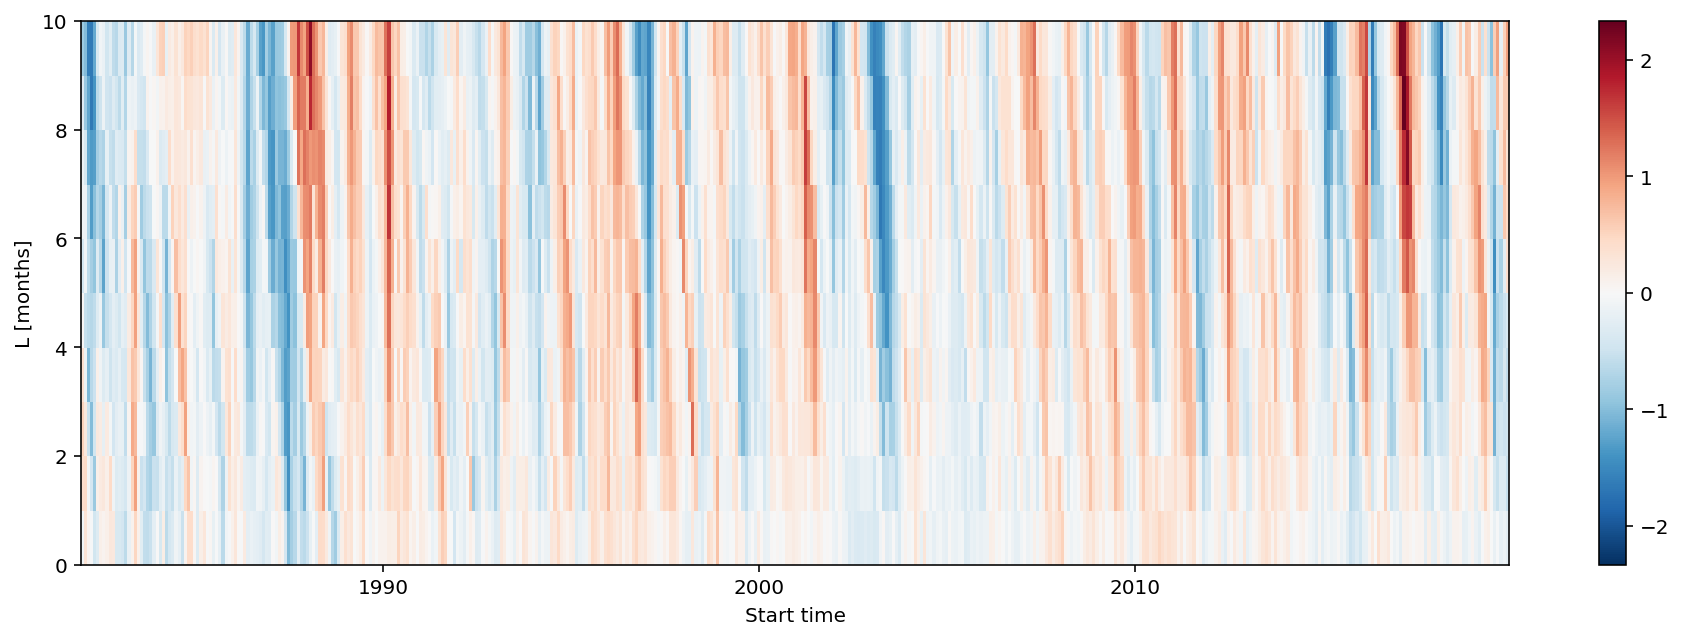

In [54]:
(fa - oa).plot(x = 'S', figsize = (16, 5));

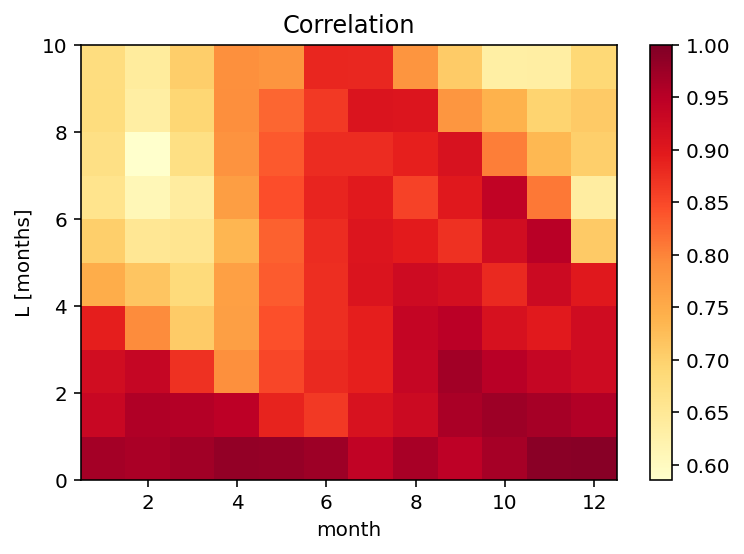

In [55]:
# Compute anomaly correlation as function of start and lead using groupby
ac = (fa*oa).groupby("S.month").mean("S")/fa.groupby("S.month").std("S")/o.groupby("S.month").std("S")
ac.plot(x="month",y="L", cmap=plt.cm.YlOrRd, vmax=1.0);
plt.title('Correlation');

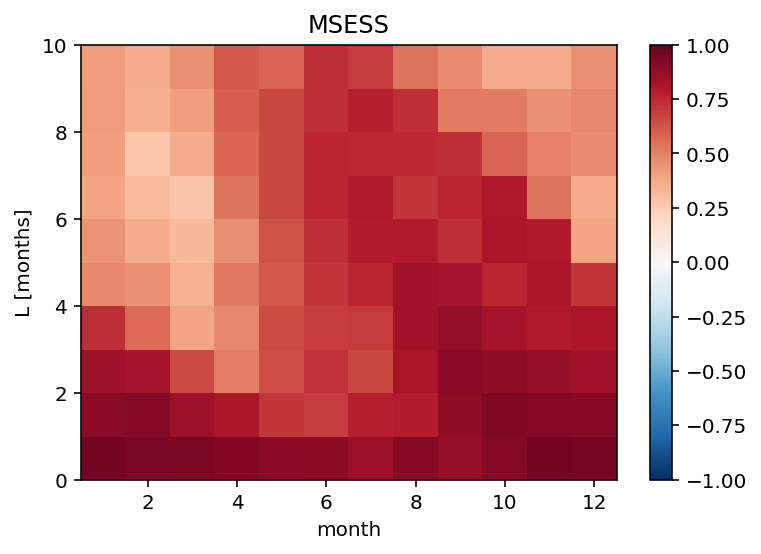

In [56]:
msess = 1 - ((fa-oa)**2).groupby("S.month").mean("S")/oa.groupby("S.month").var("S")
msess.plot(x="month",y="L", cmap='RdBu_r', vmin = -1, vmax = 1);
plt.title('MSESS');

## 4. CFSv2 probability forecasts

Outline
1. Read hindcasts and forecasts without averaging over M (ensemble members)
2. Compute probabilities of exceeding +/- 0.5
3. Compute occurrences of exceeding +/- 0.5
4. Skill scores

In [57]:
# Check if these urls work on the JupyterHub. If not add to home/.tippett/.scratch/.apma4990

# ENSEMBLE VERSION
# Nino 3.4
#nino34_str = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y/M%5Daverage/'
nino34_str = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'

#Hindcasts
cfsv2_hindcast_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.sst/' + nino34_str + 'dods'

#Hindcast verification times
#T_hindcast_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.T/dods'

#Forecasts
cfsv2_forecast_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.sst/' + nino34_str + 'dods'

#Hindcast verification times
#T_forecast_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.T/dods'

### 4.1 Hindcasts

In [58]:
# Read the hindcasts and add the verification time T
# do not decode the times
cfsv2_hindcast_ds = xr.open_dataset(cfsv2_hindcast_url,decode_times=False)
cfsv2_hindcast_ds['T'] = T_hindcast_ds.T
cfsv2_hindcast_ds

<xarray.Dataset>
Dimensions:  (L: 10, M: 28, S: 351)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * S        (S) float32 264.0 265.0 266.0 267.0 ... 611.0 612.0 613.0 614.0
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 24.0 25.0 26.0 27.0 28.0
Data variables:
    sst      (S, L, M) float64 ...
    T        (S, L) float32 ...
Attributes:
    Conventions:  IRIDL

### 4.2 Forecasts

In [59]:
# Read the forecasts
# do not decode the times
cfsv2_forecast_ds = xr.open_dataset(cfsv2_forecast_url,decode_times=False)
#T_forecast_ds = xr.open_dataset(T_forecast_url,decode_times=False)
cfsv2_forecast_ds['T'] = T_forecast_ds.T
cfsv2_forecast_ds

<xarray.Dataset>
Dimensions:  (L: 10, M: 28, S: 116)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * S        (S) float32 615.0 616.0 617.0 618.0 ... 727.0 728.0 729.0 730.0
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 24.0 25.0 26.0 27.0 28.0
Data variables:
    sst      (S, L, M) float64 ...
    T        (S, L) float32 ...
Attributes:
    Conventions:  IRIDL

### 4.3 Hindcast + forecast

In [60]:
cfsv2_all_ds = xr.concat([cfsv2_hindcast_ds, cfsv2_forecast_ds], dim = 'S')
cfsv2_all_ds.S.attrs['long_name'] = 'Start time'
cfsv2_all_ds

<xarray.Dataset>
Dimensions:  (L: 10, M: 28, S: 467)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 24.0 25.0 26.0 27.0 28.0
  * S        (S) float64 264.0 265.0 266.0 267.0 ... 727.0 728.0 729.0 730.0
Data variables:
    sst      (S, L, M) float64 26.27 26.41 26.21 26.45 ... 26.05 26.29 26.58
    T        (S, L) float32 264.5 265.5 266.5 267.5 ... 736.5 737.5 738.5 739.5
Attributes:
    Conventions:  IRIDL

### 4.4 Observations

In [61]:
cfsv2_all_ds = cfsv2_all_ds.isel(S = slice(None, 456))
cfsv2_all_ds

<xarray.Dataset>
Dimensions:  (L: 10, M: 28, S: 456)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 24.0 25.0 26.0 27.0 28.0
  * S        (S) float64 264.0 265.0 266.0 267.0 ... 716.0 717.0 718.0 719.0
Data variables:
    sst      (S, L, M) float64 26.27 26.41 26.21 26.45 26.23 ... nan nan nan nan
    T        (S, L) float32 264.5 265.5 266.5 267.5 ... 725.5 726.5 727.5 728.5
Attributes:
    Conventions:  IRIDL

In [62]:
OBS

<xarray.DataArray 'obs' (S: 456, L: 10)>
array([[26.72300908, 26.70087841, 27.19768648, ..., 27.93257255,
        28.10744101, 28.64356271],
       [26.70087841, 27.19768648, 28.01859058, ..., 28.10744101,
        28.64356271, 28.80635569],
       [27.19768648, 28.01859058, 28.53515191, ..., 28.64356271,
        28.80635569, 29.21395205],
       ...,
       [27.31348672, 27.26143751, 27.06843488, ..., 27.58841967,
        27.29897361, 26.89348991],
       [27.26143751, 27.06843488, 27.09480427, ..., 27.29897361,
        26.89348991, 26.18224381],
       [27.06843488, 27.09480427, 27.14544255, ..., 26.89348991,
        26.18224381, 25.76792853]])
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * S        (S) float64 264.0 265.0 266.0 267.0 ... 716.0 717.0 718.0 719.0

In [63]:
cfsv2_all_ds["obs"] = (( "S", "L"), OBS)
cfsv2_all_ds

<xarray.Dataset>
Dimensions:  (L: 10, M: 28, S: 456)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 24.0 25.0 26.0 27.0 28.0
  * S        (S) float64 264.0 265.0 266.0 267.0 ... 716.0 717.0 718.0 719.0
Data variables:
    sst      (S, L, M) float64 26.27 26.41 26.21 26.45 26.23 ... nan nan nan nan
    T        (S, L) float32 264.5 265.5 266.5 267.5 ... 725.5 726.5 727.5 728.5
    obs      (S, L) float64 26.72 26.7 27.2 28.02 ... 27.3 26.89 26.18 25.77
Attributes:
    Conventions:  IRIDL

In [64]:
# decoding T gives an error, maybe don't add T to the ds
cfsv2_all_ds['S'].attrs['calendar'] = '360_day'
cfsv2_all_ds['S'].attrs
cfsv2_all_ds = xr.decode_cf(cfsv2_all_ds, decode_times=True, drop_variables='T')

In [65]:
cfsv2_all_ds

<xarray.Dataset>
Dimensions:  (L: 10, M: 28, S: 456)
Coordinates:
  * L        (L) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * M        (M) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 24.0 25.0 26.0 27.0 28.0
  * S        (S) object 1982-01-01 00:00:00 ... 2019-12-01 00:00:00
Data variables:
    sst      (S, L, M) float64 ...
    obs      (S, L) float64 ...
Attributes:
    Conventions:  IRIDL

### 4.5 Two climatologies and anomalies

In [66]:
f = cfsv2_all_ds.sst
o = cfsv2_all_ds.obs

In [67]:
fc82_98 = f.sel(S = slice('1982-01','1998-12')).groupby("S.month").mean(("S", "M"))
fc99_10 = f.sel(S = slice('1999-01','2010-12')).groupby("S.month").mean(("S", "M"))

In [68]:
oc82_98 = o.sel(S = slice('1982-01','1998-12')).groupby("S.month").mean("S")
oc99_10 = o.sel(S = slice('1999-01','2010-12')).groupby("S.month").mean("S")

In [69]:
n1 = 12*17
fa = f.copy()
fa[:n1, :] = f[:n1, :].groupby('S.month') - fc82_98
fa[n1:, :] = f[n1:, :].groupby('S.month') - fc99_10

oa = o.copy()
oa[:n1, :] = o[:n1, :].groupby('S.month') - oc82_98
oa[n1:, :] = o[n1:, :].groupby('S.month') - oc99_10

### 4.6 Categorical

In [70]:
O_above = oa > 0.5;
O_below = oa < -0.5;
F_above = (fa > 0.5).mean("M")
F_below = (fa < -0.5).mean("M")

### 4.7 Brier skill scores

In [71]:
Ref_above = (0.0*oa).groupby("S.month") + (oa > 0.5).groupby("S.month").mean(("S"))
Ref_below = (0.0*oa).groupby("S.month") + (oa < -0.5).groupby("S.month").mean(("S"))

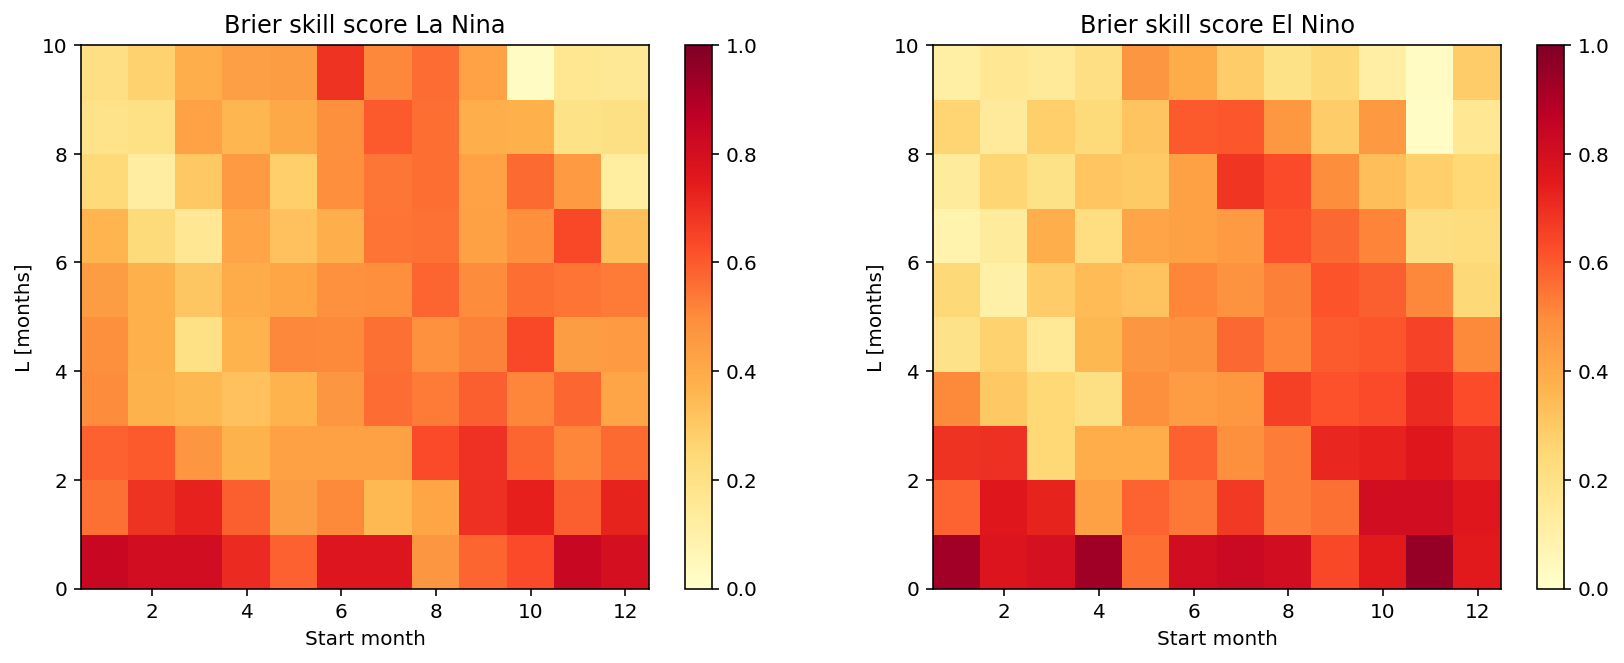

In [72]:
term1 = ((F_above - O_above)**2).groupby('S.month').mean("S")
term2 = ((Ref_above - O_above)**2).groupby('S.month').mean("S")
BSS_above = 1 - term1/term2

term1 = ((F_below - O_below)**2).groupby('S.month').mean("S")
term2 = ((Ref_below - O_below)**2).groupby('S.month').mean("S")
BSS_below = 1 - term1/term2

fig, axs = plt.subplots(1, 2, figsize = (14, 5))

ax = axs[0]
BSS_below.plot(x = 'month', ax = ax, vmin = 0, vmax = 1, cmap = 'YlOrRd');
ax.set_xlabel('Start month')
ax.set_title('Brier skill score La Nina');

ax = axs[1]
BSS_above.plot(x = 'month', ax = ax, vmin = 0, vmax = 1, cmap = 'YlOrRd');
ax.set_xlabel('Start month')
ax.set_title('Brier skill score El Nino');